In [1]:
import random
import math
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
def pow_16_():
    a = []
    for i in range(16):
        a.append(16 ** i)
    return a

pow_16 = pow_16_()

In [3]:
# load raw data
raw_data = []

with open('../data/adult-all.csv') as f:
    for line in f:
        tokens = line.strip().split(',')
        if (len(tokens)!=15):
            false_data.append(line)
            continue
        age, workclass, fnlwgt, education, education_num, marital_status, occupation, \
            relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, _ = tokens
        raw_data.append((int(age), int(education_num), int(capital_loss)))
        
n_raw = len(raw_data)
print(n_raw)

48842


In [4]:
# transform the dataset on a base of 16
# data = (age, edu, coeff, expnt)

data = []

for t in raw_data:
    age = t[0]
    edu = t[1]
    gain = t[2]
    expnt = 0
    for i in hex(gain)[2:][::-1]:
        if i > '0':
            data.append((age, edu, int('0x'+i,16), expnt))
        expnt += 1

n = len(data)

In [5]:
# define parameters
GS = 4356
eps = 1.0
u_trans = math.ceil(math.log(GS) / math.log(16))

In [6]:
# define query
Q = []

for age_length in range(11):
    for age_left in range(1, 101-age_length):
        age_right = age_left+age_length
        for edu_length in range(2):
            for edu_left in range(1, 17-edu_length):
                edu_right = edu_left+edu_length
                Q.append((age_left, age_right, edu_left, edu_right))
print(len(Q))

32395


In [7]:
def evaluate(q, histogram, tau=GS):
    ans = 0
    for age in range(q[0], q[1]+1):
        for edu in range(q[2], q[3]+1):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    x = (age, edu, coeff, expnt)
                    if x in histogram:
                        ans += min(coeff * pow_16[expnt],tau) * histogram[x]
    return ans

def evaluate_counting(q, histogram, tau):
    ans = 0
    for age in range(q[0], q[1]+1):
        for edu in range(q[2], q[3]+1):
            for coeff in range(1,16):
                for expnt in range(u_trans):
                    x = (age, edu, coeff, expnt)
                    if (x in histogram) and (coeff * pow_16[expnt] > tau):
                        ans += histogram[x]
    return ans

def evaluate_raw(q, raw_histogram, tau=GS):
    ans = 0
    for x in raw_histogram:
        age, edu, cap = x
        if (age >= q[0] and age <= q[1]):
            if (edu >= q[2] and edu <= q[3]):
                ans += min(cap, tau) * raw_histogram[x]
    return ans

def evaluate_counting_raw(q, raw_histogram, tau):
    ans = 0
    for x in raw_histogram:
        age, edu, cap = x
        if (age >= q[0] and age <= q[1]):
            if (edu >= q[2] and edu <= q[3]):
                if (cap > tau):
                    ans += raw_histogram[x]
    return ans

In [8]:
# Calculate true results
raw_histogram = Counter(raw_data)
histogram = Counter(data)
results = [evaluate(q, histogram) for q in Q]

# Composition

In [9]:
eps_0 = eps / (2*len(Q))

results_compo = []
for q_idx in range(len(Q)):
    q = Q[q_idx]
    T = np.random.laplace(0, 2 / eps_0) # threshold to compare with
    
    c = evaluate_counting_raw(q, raw_histogram, 0)
    if (c + np.random.laplace(0, 4 / eps_0) < T):
        results_compo.append(0)
        continue
        
    # else    
    tau = 1
    while (tau < GS):
        c = evaluate_counting_raw(q, raw_histogram, tau)
        if (c + np.random.laplace(0, 4 / eps_0) < T):
            ans = evaluate_raw(q, raw_histogram, tau)
            results_compo.append(ans + np.random.laplace(0, tau / eps_0))
            break
        else:
            tau = 2 * tau
    if (tau >= GS):
        results_compo.append(results[q_idx] + np.random.laplace(0, GS / eps_0))

errors_compo = [x-y for x,y in zip(results_compo, results)]

# Normalization / Global Truncation

In [10]:
T = 10
eps_0 = eps / u_trans / (2*T)
universe_size = 100 * 16 * 15 * u_trans
synthetic_histogram = {}

for age in range(1, 101):
    for edu in range(1, 17):
        for coeff in range(1,16):
            for expnt in range(u_trans):
                synthetic_histogram[(age, edu, coeff, expnt)] = n / universe_size

measurements = {}
for i in range(T):
    print("iteration: "+str(i))   
    errors = np.array([])
    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(results[qi] - evaluate(q, synthetic_histogram)) / GS / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate(Q[qi], histogram) + np.random.laplace(0, 1.0 / eps_0)
    
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi]
            error = (measurements[qi] - evaluate(q, synthetic_histogram)) / GS
            for age in range(q[0], q[1]+1):
                    for edu in range(q[2], q[3]+1):
                        for coeff in range(1,16):
                            for expnt in range(u_trans):
                                synthetic_histogram[(age, edu, coeff, expnt)] *= math.exp(coeff * pow_16[expnt] / GS * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}

synthetic_histogram_norm = synthetic_histogram
results_norm = [evaluate(q, synthetic_histogram_norm) for q in Q]
errors_norm = [x-y for x,y in zip(results_norm, results)]

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


# Ours

In [11]:
T = 10
eps_0 = eps * 0.9 / u_trans / (2*T)
universe_size = 100 * 16 * 15 * u_trans
synthetic_histogram = {}

tau_mult = 4
log_tau_mult = int(math.ceil(math.log(GS) / math.log(tau_mult)))

for age in range(1, 101):
    for edu in range(1, 17):
        for coeff in range(1,16):
            for expnt in range(u_trans):
                synthetic_histogram[(age, edu, coeff, expnt)] = n / universe_size

def evaluate_qi(qi, histogram, Q):
    q = Q[qi // (2*log_tau_mult+2)]
    tau = (qi % (2*log_tau_mult+2) + 1) // 2
    if qi % 2 == 0:
        return evaluate_counting(q, histogram, tau)
    else:
        return evaluate(q, histogram, tau) / tau

measurements = {}
for i in range(T):
    print("iteration: "+str(i))
    errors = np.array([])
    for q in Q:
        errors = np.append(errors, eps_0 * abs(evaluate_counting(q, histogram, 0) - evaluate_counting(q, synthetic_histogram, 0)) / 2.0) # counting tau = 0
        tau = 1
        while tau < GS:
            errors = np.append(errors, \
                               [eps_0 * abs(evaluate(q, histogram, tau) - evaluate(q, synthetic_histogram, tau)) / tau / 2.0,  # truncated by tau \
                                eps_0 * abs(evaluate_counting(q, histogram, tau) - evaluate_counting(q, synthetic_histogram, tau)) / 2.0]) # counting tau
            tau *= tau_mult
        errors = np.append(errors, eps_0 * abs(evaluate(q, histogram, GS) - evaluate(q, synthetic_histogram, GS)) / GS / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate_qi(qi, histogram, Q) + np.random.laplace(0, 1.0 / eps_0)

    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi // (2*log_tau_mult+2)]
            tau = (qi % (2*log_tau_mult+2) + 1) // 2
            error = measurements[qi] - evaluate_qi(qi, synthetic_histogram, Q)
            for age in range(q[0], q[1]+1):
                for edu in range(q[2], q[3]+1):
                    for coeff in range(1,16):
                        for expnt in range(u_trans):
                            if (qi % 2 == 0): # counting
                                synthetic_histogram[(age, edu, coeff, expnt)] *= math.exp(int(coeff * pow_16[expnt] > tau) * error / (2.0 * total))
                            else: # trunc
                                synthetic_histogram[(age, edu, coeff, expnt)] *= math.exp(min(coeff * pow_16[expnt], tau) / tau * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}
    
synthetic_histogram_trunc = synthetic_histogram

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [12]:
results_trunc = []

errors = np.array([])
for q in Q:
    errors = np.append(errors, eps_0 * abs(evaluate_counting(q, histogram, 0) - evaluate_counting(q, synthetic_histogram_trunc, 0)) / 2.0) # counting tau = 0
    tau = 1
    while tau < GS:
        errors = np.append(errors, \
                           [abs(evaluate(q, histogram, tau) - evaluate(q, synthetic_histogram_trunc, tau)) / tau,  # truncated by tau \
                            abs(evaluate_counting(q, histogram, tau) - evaluate_counting(q, synthetic_histogram_trunc, tau))]) # counting tau
        tau *= tau_mult
max_error = errors.max() + np.random.laplace(0, 10 / eps)
print(max_error)

for q in Q:
    tau = 0
    c = evaluate_counting(q, synthetic_histogram_trunc, 0)
    if c <= max_error:
        results_trunc.append(0)
    else:
        R = 1
        while R < GS:
            ans = evaluate_counting(q, synthetic_histogram_trunc, R)
            if ans <= max_error:
                break
            else:
                R = tau_mult * R
        tau = min(GS, R)
        res = evaluate(q, synthetic_histogram_trunc, tau)
        results_trunc.append(res)

errors_trunc = [x-y for x,y in zip(results_trunc, results)]

791.4112488484228


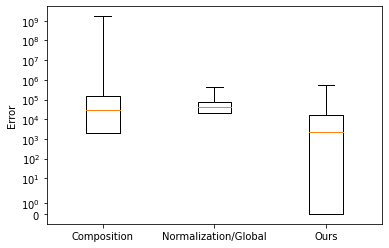

In [13]:
plt.ylabel('Error')
plt.boxplot([[abs(x) for x in errors_compo], [abs(x) for x in errors_norm], [abs(x) for x in errors_trunc]], \
            labels=['Composition', 'Normalization/Global', 'Ours'], whis=(25,100), showfliers=False)
plt.yscale("symlog")
plt.show()